In [1]:
import numpy as np
import pandas as pd

from sklearn import svm 
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

In [2]:
def preprocess_features (data):

  #1st step: average data over 12 hour stay
  import warnings 
  mean_ls = []
  for idx in data.pid.unique():
    tmp_df = data.loc[data['pid'] == idx]
    # I expect to see RuntimeWarnings in this block
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=RuntimeWarning)
      mean_row = np.nanmean(tmp_df, axis = 0)
    mean_ls.append(mean_row)
    #create dataframe out of list
  mean_df = pd.DataFrame(data = mean_ls, columns = data.columns)

  #2nd step remove pid colum 
  mean_df.drop('pid', axis = 1, inplace = True)

  #3rd step remove time column
  mean_df.drop('Time', axis = 1, inplace = True)

  #4th step: centralize data
  centered_df = mean_df - np.nanmean(mean_df, axis=0)

  #5th step: set nans to zero after scaling
  filled_df = centered_df.fillna(-1)

  #6th step: scale data
  scaled_df = filled_df / np.nanstd(filled_df, axis=0)
  
  return scaled_df

In [4]:
#load train labels 
train_labels = pd.read_csv('train_labels.csv')
print(train_labels.shape)
#load train features 
train_features = pd.read_csv('train_features.csv')
print(train_features.shape)
train_features_preprocessed = preprocess_features(train_features)
train_features_preprocessed.to_csv('preprocessed_features_ck.csv',index=False)
#load test_features 
test_features = pd.read_csv('test_features.csv')
print(test_features.shape)
test_features_preprocessed = preprocess_features(test_features)
#initalize output matrix 
output = pd.DataFrame(data = test_features.pid.unique(), columns = ['pid'])
#define sigmoid function 
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

(18995, 16)
(227940, 37)
(151968, 37)


In [4]:
# Evaluate Imbalance
medical_test_ls = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2', 'LABEL_Sepsis']
for label in medical_test_ls:
  print(label)
  tmp_df = train_labels.loc[train_labels[label] == 1]
  print('nr. 0 labels:', train_labels.shape[0] - tmp_df.shape[0])
  print('nr. 1 labels:', tmp_df.shape[0])

LABEL_BaseExcess
nr. 0 labels: 13899
nr. 1 labels: 5096
LABEL_Fibrinogen
nr. 0 labels: 17595
nr. 1 labels: 1400
LABEL_AST
nr. 0 labels: 14441
nr. 1 labels: 4554
LABEL_Alkalinephos
nr. 0 labels: 14508
nr. 1 labels: 4487
LABEL_Bilirubin_total
nr. 0 labels: 14425
nr. 1 labels: 4570
LABEL_Lactate
nr. 0 labels: 15192
nr. 1 labels: 3803
LABEL_TroponinI
nr. 0 labels: 17100
nr. 1 labels: 1895
LABEL_SaO2
nr. 0 labels: 14556
nr. 1 labels: 4439
LABEL_Bilirubin_direct
nr. 0 labels: 18351
nr. 1 labels: 644
LABEL_EtCO2
nr. 0 labels: 17741
nr. 1 labels: 1254
LABEL_Sepsis
nr. 0 labels: 17907
nr. 1 labels: 1088


In [5]:
#resample data 
medical_test_ls = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2', 'LABEL_Sepsis']
labels_only = pd.DataFrame(data = train_labels, columns = train_labels.columns[1:])
print(labels_only.shape)
df_train = pd.concat([train_features_preprocessed, labels_only], axis=1)
#print(df_train.columns)
print(train_features_preprocessed.shape)
resampled_data = []
#print(df_train.columns)
for label in medical_test_ls:
  # Class count
  count_class_0, count_class_1 = df_train[label].value_counts()
  # Divide by class
  df_class_0 = df_train[df_train[label] == 0]
  df_class_1 = df_train[df_train[label] == 1]
  df_class_0_under = df_class_0.sample(count_class_1)
  df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
  print(df_test_under[label].value_counts())
  resampled_data.append(df_test_under)
print(resampled_data[0])

(18995, 15)
(18995, 35)
1.0    5096
0.0    5096
Name: LABEL_BaseExcess, dtype: int64
1.0    1400
0.0    1400
Name: LABEL_Fibrinogen, dtype: int64
1.0    4554
0.0    4554
Name: LABEL_AST, dtype: int64
1.0    4487
0.0    4487
Name: LABEL_Alkalinephos, dtype: int64
1.0    4570
0.0    4570
Name: LABEL_Bilirubin_total, dtype: int64
1.0    3803
0.0    3803
Name: LABEL_Lactate, dtype: int64
1.0    1895
0.0    1895
Name: LABEL_TroponinI, dtype: int64
1.0    4439
0.0    4439
Name: LABEL_SaO2, dtype: int64
1.0    644
0.0    644
Name: LABEL_Bilirubin_direct, dtype: int64
1.0    1254
0.0    1254
Name: LABEL_EtCO2, dtype: int64
1.0    1088
0.0    1088
Name: LABEL_Sepsis, dtype: int64
            Age     EtCO2       PTT  ...  LABEL_ABPm  LABEL_SpO2  LABEL_Heartrate
13433  2.305289 -0.440574 -0.065497  ...        74.1        97.8             94.5
6603  -1.524075 -5.322052 -0.635418  ...        88.6        99.3            116.6
6490   0.724916 -0.440574 -0.065497  ...        56.7        98.2          

In [6]:
#train classifiers for subtask 1 and 2
medical_test_ls = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2', 'LABEL_Sepsis']
classifiers_sub_1_2 = []
parameters = [1.5, 2, 5, 10]
for idx,label in enumerate(medical_test_ls):
    print(label)
    X = resampled_data[idx].iloc[:,0:35]
    print(X.shape)
    y = resampled_data[idx][label]
    classifier = svm.SVC(C = 64)
    lambda_score = (64, np.mean(cross_val_score (classifier,X,y, cv = 5, scoring = 'roc_auc')))
    print(lambda_score)
    for c in parameters:
      classifier = svm.SVC(C = c)
      scores = cross_val_score(classifier,X,y, cv = 5, scoring = 'roc_auc' )
      mean = np.mean(scores)
      print((c,mean))
      if (mean > lambda_score[1]):
        lambda_score = (c, mean)
        print(lambda_score[1])
    best_classifier = svm.SVC(C = lambda_score[0]).fit(X,y)
    print(best_classifier.get_params)
    classifiers_sub_1_2.append(best_classifier)




'''print(label)
  X = resampled_data[idx].iloc[:,0:35]
  print(X.shape)
  y = resampled_data[idx][label]
  print(y.shape)
  classifier = svm.SVC()
  search = GridSearchCV(estimator=classifier, param_grid=parameters, refit = True, cv = 5, n_jobs = -1)
  #search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring = 'roc_auc',  refit = True, cv = 5, n_jobs = -1, verbose = 3)
  search.fit(X,y)
  best_classifier = search.best_estimator_
  print(best_classifier.get_params)
  classifiers_sub_1_2.append(best_classifier)'''

LABEL_BaseExcess
(10192, 35)
(64, 0.8566555779242668)
(1.5, 0.8765972914969634)
0.8765972914969634
(2, 0.8773059159919278)
0.8773059159919278
(5, 0.8776615987061509)
0.8776615987061509
(10, 0.8765646036699881)
<bound method BaseEstimator.get_params of SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>
LABEL_Fibrinogen
(2800, 35)
(64, 0.7149489795918367)
(1.5, 0.7687755102040816)
0.7687755102040816
(2, 0.7684617346938776)
(5, 0.7574591836734694)
(10, 0.7476938775510205)
<bound method BaseEstimator.get_params of SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>
LABEL_AST
(9108, 35)
(64, 0.6616833

"print(label)\n  X = resampled_data[idx].iloc[:,0:35]\n  print(X.shape)\n  y = resampled_data[idx][label]\n  print(y.shape)\n  classifier = svm.SVC()\n  search = GridSearchCV(estimator=classifier, param_grid=parameters, refit = True, cv = 5, n_jobs = -1)\n  #search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring = 'roc_auc',  refit = True, cv = 5, n_jobs = -1, verbose = 3)\n  search.fit(X,y)\n  best_classifier = search.best_estimator_\n  print(best_classifier.get_params)\n  classifiers_sub_1_2.append(best_classifier)"

<bound method BaseEstimator.get_params of SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>
Confusion matrix:
 [[1287  113]
 [ 488  912]]


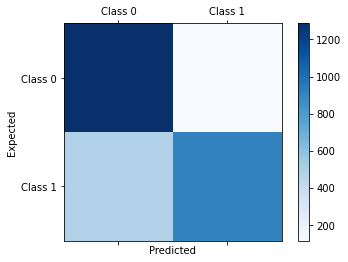

In [7]:
# confusion_matrix 
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
#
idx = 1
classifier = classifiers_sub_1_2[idx]
X = resampled_data[idx].iloc[:,:35]
print(classifier.get_params)
y = resampled_data[idx][medical_test_ls[idx]]
conf_mat = confusion_matrix(y_true= y, y_pred=classifier.predict(X))
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
#we analyzed the confusion matrix and soo that it classifies wrong so we had to increase the error a lot 

In [8]:
#Predicitons for subtaks 1_2
for idx, label in enumerate(medical_test_ls):
  best_classifier = classifiers_sub_1_2[idx]
  x = best_classifier.decision_function(test_features_preprocessed)
  #does this workrk?
  prediction = sigmoid(x)
  #add predictions to output matrix 
  output[label] = prediction

In [9]:
'''#train model for subtask 3
vital_signs_ls = ['LABEL_RRate', 'LABEL_ABPm' , 'LABEL_SpO2', 'LABEL_Heartrate']
regressors_vital_signs = []
X = train_features_preprocessed
parameters = [{'C': [1, 5, 10, 15, 20], 'kernel': ['rbf']}]
for label in vital_signs_ls:
  print(label)
  y = train_labels[label] 
  regressor = svm.SVR()
  search = GridSearchCV(estimator=regressor, param_grid=parameters, refit = True, cv = 5)
  search.fit(X,y)
  best_regressor = search.best_estimator_
   print(best_regressor.get_params)
  regressors_vital_signs.append(best_regressors)'''
#hard coded weights
#train model for subtask 3
vital_signs_ls = ['LABEL_RRate', 'LABEL_ABPm' , 'LABEL_SpO2', 'LABEL_Heartrate']
regressors_vital_signs = []
X = train_features_preprocessed
parameters = [5,10,5,20]
for idx,label in enumerate(vital_signs_ls):
  y = train_labels[label]
  c = parameters[idx]
  regressor = svm.SVR(C = c)
  fitted_regressor = regressor.fit(X,y)
  regressors_vital_signs.append(fitted_regressor)

In [10]:
#Predictions for subtask_3
for idx, label in enumerate(vital_signs_ls):
  best_regressor = regressors_vital_signs[idx]
  prediction = best_regressor.predict(test_features_preprocessed)
  #add predictions to output matrix 
  output[label] = prediction 

In [11]:
output.to_csv('predictions.zip', index = False, float_format='%.3f', compression='zip')

In [12]:
output.to_csv('predictions.csv', index = False, float_format='%.3f')